In [12]:
!pip install torch torchvision torchaudio

In [13]:
import torch
import torch.nn as nn
import torch.functional as F
import numpy as np

In [14]:
import torchvision.datasets as datasets

In [15]:
dataset_path="~/datasets"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_dim = 784 # each image is 28*28 = 784 pixels
batch_size = 100
hidden_dim = 400
latent_dim = 200
learning_rate = 1e-4
epochs = 30

In [16]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# MNIST
mnist_transform = transforms.Compose([
    transforms.ToTensor()
])

kwargs = {'num_workers':1, 'pin_memory':True}
train_dataset = MNIST(dataset_path, transform=mnist_transform,train=True, download=True)
test_dataset = MNIST(dataset_path, transform=mnist_transform, train=False, download=False)

train_loader = DataLoader(dataset=train_dataset, batch_size = batch_size, shuffle=True,**kwargs)
test_loader = DataLoader(dataset=test_dataset, batch_size = batch_size,shuffle=True , **kwargs)

In [17]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim , latent_dim):
        super(Encoder, self).__init__()
        # Hidden layers used to process the inputs before converting to latents
        self.hidden_layer = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(0.2),
            nn.Linear(hidden_dim , hidden_dim),
            nn.LeakyReLU(0.2)
        )
        # Laten representations encoded into mean and lo variance vector
        self.mean = nn.Linear(hidden_dim, latent_dim)
        self.log_variance = nn.Linear(hidden_dim, latent_dim)
        self.training = True
    def forward(self, x):
        hidden = self.hidden_layer(x)
        mean = self.mean(hidden)
        log_variance = self.log_variance(hidden)
        return mean, log_variance

In [18]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder , self).__init__()
        self.hidden_layer = nn.Sequential(
            nn.Linear(latent_dim , hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim , hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim , output_dim)
        )
    def forward(self, x):
        hidden = self.hidden_layer(x)
        x_hat = torch.sigmoid(hidden)
        return x_hat

In [28]:
class Model(nn.Module):
    def __init__(self, Encoder , Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
    def reparameterization(self , mean , variance):
        epslion = torch.randn_like(variance).to(device)
        z = mean + variance * epslion
        return z
    def forward(self, x):
        mean , log_variance = self.Encoder(x)
        # Use the reparameterization trick to keep randomness differentiable 
        z = self.reparameterization(mean, torch.exp(0.5 * log_variance))
        x_hat = self.Decoder(z)
        return x_hat, mean , log_variance
        

In [29]:
encoder = Encoder(input_dim=data_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim=hidden_dim, output_dim = data_dim)

model = Model(Encoder=encoder, Decoder=decoder).to(device)

In [30]:
from torch.optim import Adam
def bce_loss(x , x_hat, mean , log_variance):
    # reconstruction loss encourages latents to model distribution better 
    reconstruction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    # Kl div penalize latens from deviating tooo for from gaussion
    kl_divergence = -0.5 * torch.sum(1+log_variance - mean.pow(2) - log_variance.exp())
    return reconstruction_loss + kl_divergence

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

In [33]:
model.train()
for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.view(batch_size, data_dim)
        x = x.to(device)
        optimizer.zero_grad()
        x_hat, mean, log_variance = model(x)
        loss = bce_loss(x , x_hat , mean , log_variance)
        overall_loss += loss.item()
        loss.backward()
        optimizer.step()
    print(f"epoch {epoch + 1} : average loss {overall_loss / (batch_idx*batch_size)}")
    

epoch 1 : average loss 178.67416139529425
epoch 2 : average loss 131.8007163469063
epoch 3 : average loss 118.90000586915693
epoch 4 : average loss 114.4904286277911
epoch 5 : average loss 111.68894749713064
epoch 6 : average loss 110.02432250365192
epoch 7 : average loss 108.56211543979549
epoch 8 : average loss 107.40566761660058
epoch 9 : average loss 106.60327194086499
epoch 10 : average loss 105.92848927900668
epoch 11 : average loss 105.40957236670492
epoch 12 : average loss 104.8920472108462
epoch 13 : average loss 104.50051053513668
epoch 14 : average loss 104.08471038971201
epoch 15 : average loss 103.73186733748956
epoch 16 : average loss 103.26219490165902
epoch 17 : average loss 103.04608869600375
epoch 18 : average loss 102.65869893833472
epoch 19 : average loss 102.52666108553318
epoch 20 : average loss 102.26652596449811
epoch 21 : average loss 102.11287200672997
epoch 22 : average loss 101.85222956229131
epoch 23 : average loss 101.7031161962646
epoch 24 : average loss 

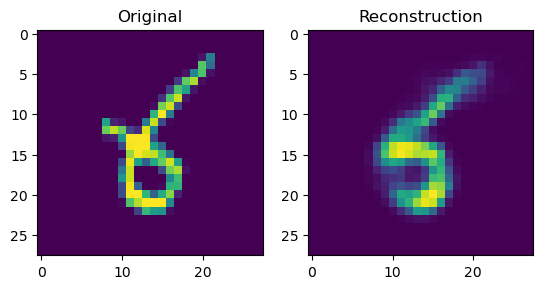

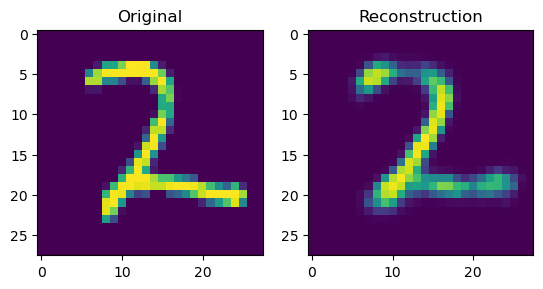

In [36]:
import matplotlib.pyplot as plt
from tqdm import tqdm

model.eval()

def show_image(x, idx, figure=True):
    if figure:
      fig = plt.figure()

    x = x.view(batch_size, 28, 28)
    plt.imshow(x[idx].cpu().numpy())

def show_comparison(x, x_hat, idx):
    fig = plt.figure()
    plt.subplot(1, 2, 1)
    show_image(x, idx, False)
    plt.title("Original")
    plt.subplot(1, 2, 2)
    show_image(x_hat, idx, False)
    plt.title("Reconstruction")

x, _ = next(iter(test_loader))
with torch.no_grad():
      x = x.view(batch_size, data_dim)
      x = x.to(device)

      x_hat, _, _ = model(x)

show_comparison(x, x_hat, 3) # digit 2
show_comparison(x, x_hat, 5) # digit 4